<a href="https://colab.research.google.com/github/sadiya2005/Smart-Prediction-Models-for-Energy-Efficiency-for-Buildings-/blob/main/mini_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
# Load datasets (Make sure the file names match your dataset)
train_df = pd.read_csv("Training Data.csv")
test_df = pd.read_csv("Test Data.csv")
metadata_df = pd.read_csv("Building Metadata.csv")

# Merge metadata with train & test data based on series_id
train_df = train_df.merge(metadata_df, on="series_id", how="left")
test_df = test_df.merge(metadata_df, on="series_id", how="left")

# Display first few rows to confirm merge
print("Train Data after merging:")
print(train_df.head())

print("\nTest Data after merging:")
print(test_df.head())


Train Data after merging:
   series_id            timestamp    consumption  temperature   surface  \
0     101869  2013-04-28 03:00:00  186668.524814    14.300000   x-large   
1     100043  2017-11-22 13:00:00   70460.369717          NaN   x-small   
2     103425  2016-04-20 06:00:00   67706.543361     4.333333  xx-large   
3     103425  2016-05-04 23:00:00   35042.519324     9.666667  xx-large   
4     101405  2015-10-14 05:00:00   29874.425364          NaN  xx-large   

  base_temperature  monday_is_day_off  tuesday_is_day_off  \
0              low              False               False   
1              low              False               False   
2              low              False               False   
3              low              False               False   
4              low              False               False   

   wednesday_is_day_off  thursday_is_day_off  friday_is_day_off  \
0                 False                False              False   
1                 Fals

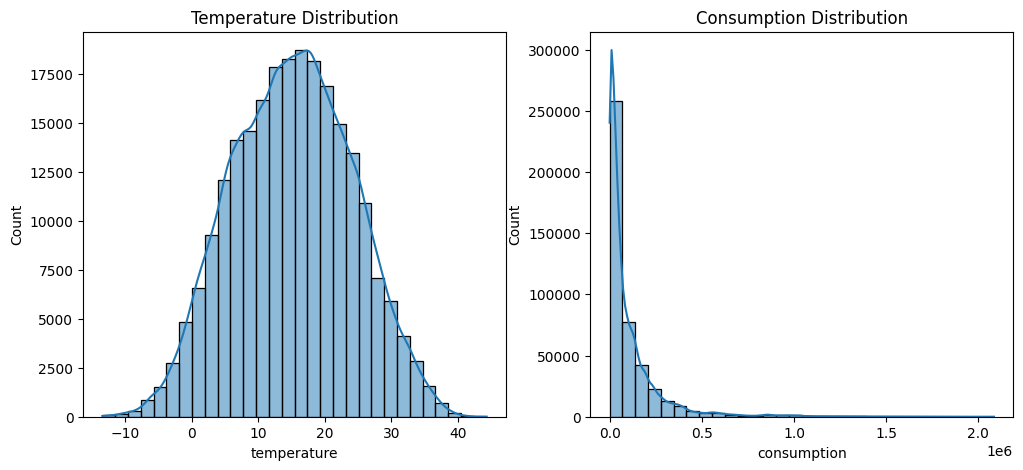

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df["temperature"].dropna(), bins=30, kde=True)
plt.title("Temperature Distribution")

plt.subplot(1, 2, 2)
sns.histplot(train_df["consumption"].dropna(), bins=30, kde=True)
plt.title("Consumption Distribution")

plt.show()

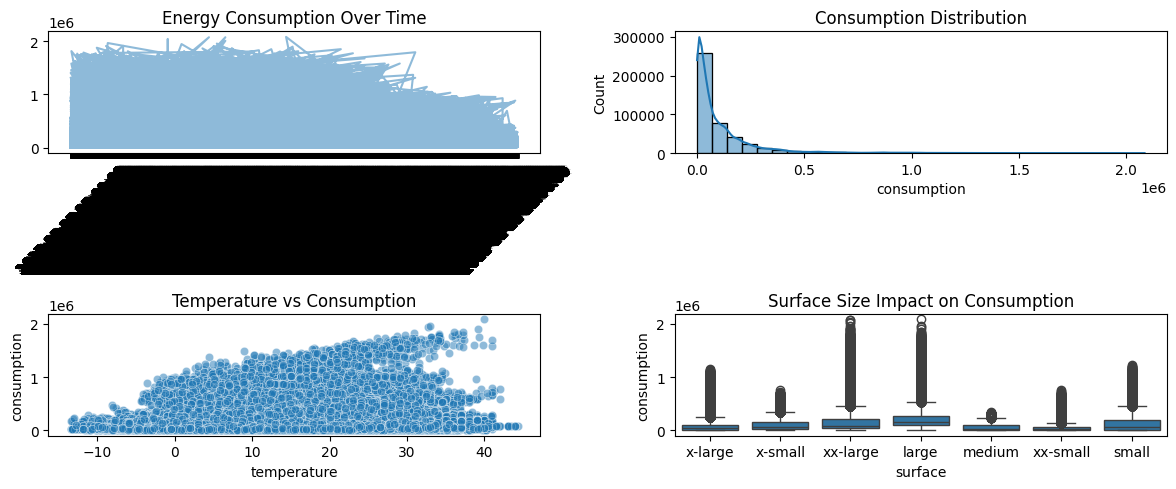

In [ ]:


plt.figure(figsize=(12, 5))

# ✅ Energy Consumption Over Time
plt.subplot(2, 2, 1)
plt.plot(train_df["timestamp"], train_df["consumption"], alpha=0.5)
plt.xticks(rotation=45)
plt.title("Energy Consumption Over Time")

# ✅ Distribution of Energy Consumption
plt.subplot(2, 2, 2)
sns.histplot(train_df["consumption"].dropna(), bins=30, kde=True)
plt.title("Consumption Distribution")

# ✅ Temperature vs Energy Consumption
plt.subplot(2, 2, 3)
sns.scatterplot(x=train_df["temperature"], y=train_df["consumption"], alpha=0.5)
plt.title("Temperature vs Consumption")

# ✅ Surface Size Impact on Consumption
plt.subplot(2, 2, 4)
sns.boxplot(x=train_df["surface"], y=train_df["consumption"])
plt.title("Surface Size Impact on Consumption")

plt.tight_layout()
plt.show()


# **Data Preprocessing**

**1)Handiling missing values**

In [ ]:
# Interpolate missing values for numerical columns
train_df["temperature"] = train_df["temperature"].interpolate(method='linear')
test_df["temperature"] = test_df["temperature"].interpolate(method='linear')

train_df["consumption"] = train_df["consumption"].interpolate(method='linear')
test_df["consumption"] = test_df["consumption"].interpolate(method='linear')

# Fill missing categorical values
train_df["surface"].fillna("medium", inplace=True)
test_df["surface"].fillna("medium", inplace=True)



<ipython-input-4-ce76abce2493>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["surface"].fillna("medium", inplace=True)
<ipython-input-4-ce76abce2493>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

**2)Encode Categorical Features**

In [ ]:
# Encode 'surface' using ordinal encoding
surface_mapping = {
    "xx-small": 0,
    "x-small": 1,
    "small": 2,
    "medium": 3,
    "large": 4,
    "x-large": 5,
    "xx-large": 6
}

train_df["surface"] = train_df["surface"].map(surface_mapping)
test_df["surface"] = test_df["surface"].map(surface_mapping)

# Drop 'base_temperature' since it's not needed
train_df.drop(columns=["base_temperature"], inplace=True, errors="ignore")
test_df.drop(columns=["base_temperature"], inplace=True, errors="ignore")


**3)Convert Timestamp to Datetime & Extract Features**

In [ ]:
# Convert timestamp to datetime format
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

# Extract useful time-based features
for df in [train_df, test_df]:
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["month"] = df["timestamp"].dt.month
    df["weekday"] = df["timestamp"].dt.weekday  # 0 = Monday, 6 = Sunday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)  # 1 if weekend, else 0


**4) Feature Scaling for LSTM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the features to scale
scaled_features = ["temperature", "consumption"]

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on train data and transform both train and test sets
train_df[scaled_features] = scaler.fit_transform(train_df[scaled_features])
test_df[scaled_features] = scaler.transform(test_df[scaled_features])


# **Reshape Data for LSTM**

In [ ]:

# Define sequence length (e.g., past 24 time steps)
sequence_length = 24

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length].values)
        y.append(data.iloc[i + seq_length]["consumption"])
    return np.array(X), np.array(y)

# Convert train dataset into sequences
X_train, y_train = create_sequences(train_df[["temperature", "consumption"]], sequence_length)

# Convert test dataset into sequences
X_test, y_test = create_sequences(test_df[["temperature", "consumption"]], sequence_length)

# Reshape input data to (samples, time steps, features)
print(f"Training Data Shape: {X_train.shape}, Labels Shape: {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, Labels Shape: {y_test.shape}")


NameError: name 'np' is not defined

# **Build and Train the LSTM Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM Model Architecture
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)  # Output layer (predicting consumption)
])

# Compile the Model with RMSE as a metric
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# Save the trained model
model.save("lstm_energy_model.h5")

# Print Model Summary
model.summary()


In [ ]:
# Evaluate the model on the test set
loss, rmse = model.evaluate(X_test, y_test, verbose=1)

# Calculate R² score
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse}")
print(f"R² Score: {r2}")
